In [1]:
! pip install torchsummary


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip




# A smart system for Personalized Interior Design and Augmented Reality Try-On


# Importing Libraries

Libraries Imported:

<!-- # os, pathlib.Path: For file system operations (e.g., checking directories, handling paths).
# torch, torchvision: For deep learning, including datasets, models, and transforms.
# torch.nn, torch.nn.functional: For neural network layers and functions (e.g., loss calculation).
# matplotlib.pyplot, seaborn, numpy, pandas: For data visualization and analysis.
# PIL.Image: For image loading and verification.
# urllib.request: For downloading external images.
# collections.Counter: For counting class occurrences in EDA.
# torch.optim.lr_scheduler.ReduceLROnPlateau: For adaptive learning rate scheduling. -->

In [26]:
import os
import torch
import torchvision
from torch.utils.data import random_split, WeightedRandomSampler
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
import seaborn as sns
from collections import Counter
import urllib.request
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd

In [27]:
# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)


# Loading the dataset

In [4]:
data_dir = 'home_interior_dataset'

# ETL: Extract - Check if dataset exists

In [28]:
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Dataset directory {data_dir} not found. Please ensure the dataset is available.")


# Verify dataset integrity

# ETL: Transform - Define data augmentations for training to handle imbalanced dataset

In [31]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/Test transforms (no augmentation, only resizing and normalization)

In [32]:
val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# ETL: Load - Load dataset

In [33]:
try:
    dataset = torchvision.datasets.ImageFolder(data_dir, transform=train_transforms)
    val_test_dataset = torchvision.datasets.ImageFolder(data_dir, transform=val_test_transforms)
except Exception as e:
    raise RuntimeError(f"Error loading dataset: {e}")


In [34]:
if len(dataset) != 3348:
    print(f"Warning: Expected 3348 images, but found {len(dataset)} images.")

# EDA: Dataset Statistics

In [35]:
classes = dataset.classes
print("Classes:", classes)
print("Total classes:", len(classes))
print("Total images:", len(dataset))

Classes: ['bathroom', 'bedroom', 'children_room', 'closet', 'dining_room', 'kitchen', 'livingroom', 'nursery', 'pantry']
Total classes: 9
Total images: 3348



# Class-wise counts

In [36]:
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
print("\nClass-wise counts:")
for cls, count in class_counts.items():
    print(f"{classes[cls]}: {count}")
print(f"Average images per class: {len(dataset) / len(classes):.1f}")



Class-wise counts:
bathroom: 197
bedroom: 662
children_room: 112
closet: 135
dining_room: 274
kitchen: 734
livingroom: 706
nursery: 144
pantry: 384
Average images per class: 372.0


# EDA: Visualize class distribution

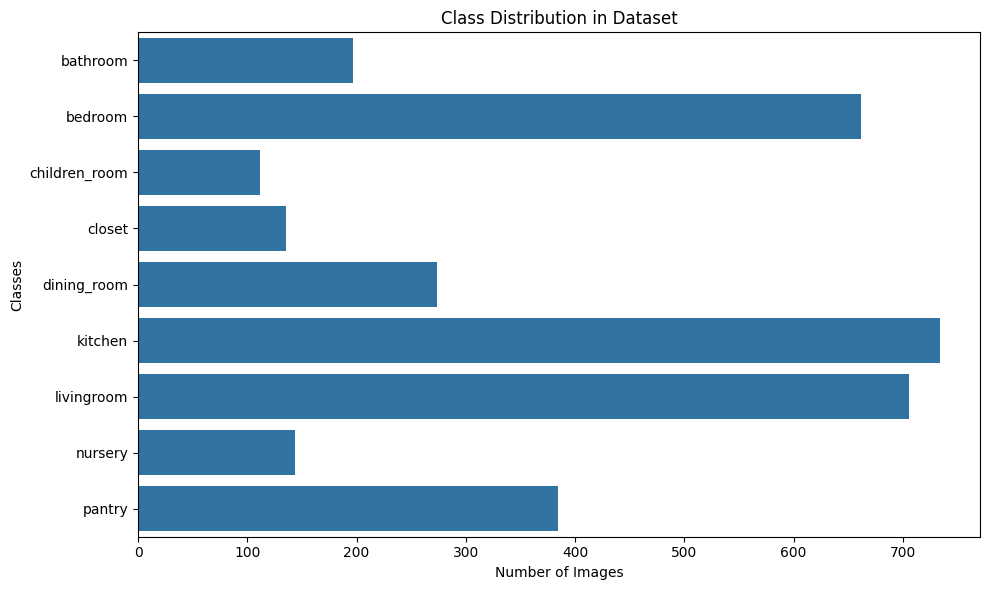

In [37]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.values()), y=[classes[i] for i in class_counts.keys()])
plt.title('Class Distribution in Dataset')
plt.xlabel('Number of Images')
plt.ylabel('Classes')
plt.tight_layout()
plt.show()

# Handle imbalanced dataset with WeightedRandomSampler

In [39]:
class_weights = [1.0 / class_counts[i] for i in range(len(classes))]
weights = []
train_indices = []
for idx, (_, label) in enumerate(dataset.samples):
    if idx >= len(dataset):
        raise ValueError(f"Index {idx} out of range for dataset of size {len(dataset)}")
    weights.append(class_weights[label])
    train_indices.append(idx)  # Collect all indices initially


# Split dataset

In [40]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")


Train size: 2343, Validation size: 502, Test size: 503


# Verify subset indices

In [41]:
for split, name in [(train_ds, "train"), (val_ds, "validation"), (test_ds, "test")]:
    if any(idx >= len(dataset) for idx in split.indices):
        raise ValueError(f"Invalid indices in {name} split: {split.indices}")

# Adjust weights for train_ds only

In [42]:
train_weights = [weights[idx] for idx in train_ds.indices]
if len(train_weights) != len(train_ds):
    raise ValueError(f"Mismatch between train weights ({len(train_weights)}) and train dataset size ({len(train_ds)}).")
sampler = WeightedRandomSampler(train_weights, len(train_weights), replacement=True)


# Data Loaders

In [44]:
batch_size = 32
num_workers = 0  # Set to 0 for Windows compatibility
try:
    train_dl = torch.utils.data.DataLoader(
        train_ds, batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True
    )
    val_dl = torch.utils.data.DataLoader(
        val_ds, batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True
    )
    test_dl = torch.utils.data.DataLoader(
        test_ds, batch_size*2, shuffle=False, num_workers=num_workers, pin_memory=True
    )
except Exception as e:
    raise RuntimeError(f"Error creating DataLoader: {e}")

# Debug DataLoader

In [45]:
try:
    for i, (images, labels) in enumerate(train_dl):
        print(f"Batch {i}: Images shape: {images.shape}, Labels shape: {labels.shape}")
        break
except Exception as e:
    print(f"Error testing DataLoader: {e}")

Batch 0: Images shape: torch.Size([32, 3, 256, 256]), Labels shape: torch.Size([32])


# Helper function to show sample image

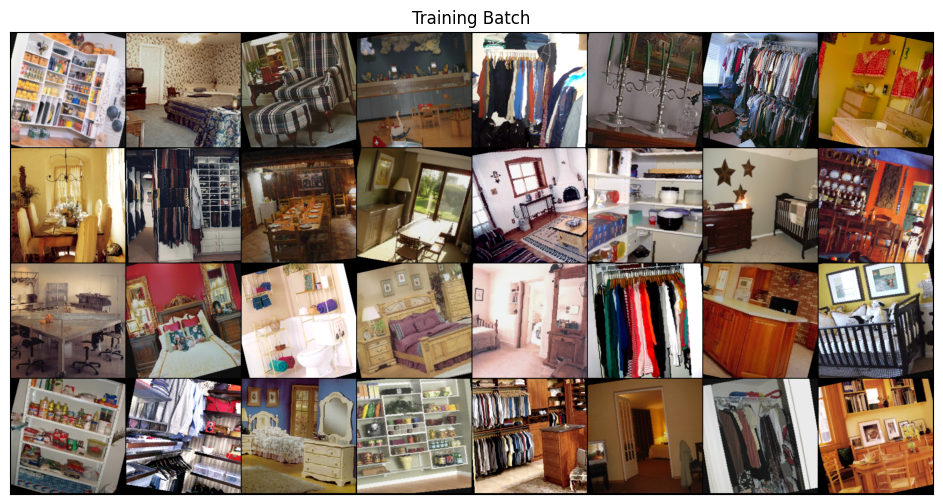

In [46]:
def show_batch(dl, title="Sample Batch from DataLoader"):
    try:
        for images, labels in dl:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.set_xticks([])
            ax.set_yticks([])
            mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1)
            std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1)
            images = images * std + mean
            images = images.clamp(0, 1)
            ax.imshow(torchvision.utils.make_grid(images, nrow=8).permute(1, 2, 0))
            plt.title(title)
            plt.show()
            break
    except Exception as e:
        print(f"Error visualizing batch: {e}")

show_batch(train_dl, title="Training Batch")


# Helper function to show sample image

In [47]:
def show_sample(img, label):
    try:
        print("Label:", dataset.classes[label], "(Class No: " + str(label) + ")")
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        img = img * std + mean
        img = img.clamp(0, 1)
        plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error visualizing sample: {e}")

# Visualize a sample image

Label: bedroom (Class No: 1)


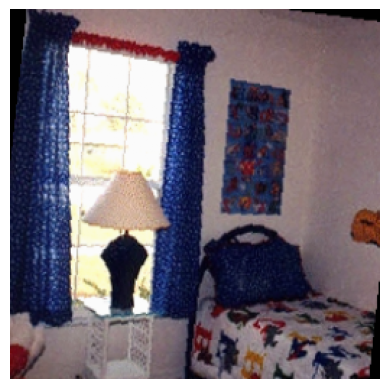

In [49]:
try:
    img, label = dataset[600]
    show_sample(img, label)
except Exception as e:
    print(f"Error visualizing sample: {e}")

# Model Definition

In [50]:
class ResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        for param in self.network.parameters():
            param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Device configuration

In [52]:
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        try:
            for b in self.dl:
                yield to_device(b, self.device)
        except Exception as e:
            print(f"Error in DeviceDataLoader iteration: {e}")
            raise
    
    def __len__(self):
        return len(self.dl)

device = get_default_device()
print(f"Using device: {device}")
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

Using device: cpu


# Evaluation function

In [54]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = []
    try:
        for batch in val_loader:
            outputs.append(model.validation_step(batch))
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return {'val_loss': float('inf'), 'val_acc': 0.0}
    return model.validation_epoch_end(outputs)



# Early stopping

In [55]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.Inf
    
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'checkpoint.pt')

# Training function

In [57]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam, patience=5):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        try:
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
        except Exception as e:
            print(f"Error during training epoch {epoch+1}: {e}")
            break
        
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item() if train_losses else float('inf')
        model.epoch_end(epoch, result)
        history.append(result)
        
        scheduler.step(result['val_loss'])
        print(f"Learning rate: {scheduler.get_last_lr()[0]:.6f}")
        early_stopping(result['val_loss'], model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(torch.load('checkpoint.pt'))
            break
    
    return history


# Hyperparameter tuning

In [58]:
hyperparams = [
    {'lr': 1e-4, 'epochs': 20, 'dropout_rate': 0.5},
    {'lr': 6e-5, 'epochs': 20, 'dropout_rate': 0.3},
    {'lr': 3e-5, 'epochs': 20, 'dropout_rate': 0.4}
]

best_val_acc = 0
best_model = None
best_history = None

for param in hyperparams:
    print(f"\nTraining with lr={param['lr']}, dropout={param['dropout_rate']}")
    try:
        model = ResNet(num_classes=len(classes), dropout_rate=param['dropout_rate'])
        model = to_device(model, device)
        history = fit(param['epochs'], param['lr'], model, train_dl, val_dl, torch.optim.Adam, patience=5)
        
        final_val_acc = history[-1]['val_acc'] if history else 0.0
        if final_val_acc > best_val_acc:
            best_val_acc = final_val_acc
            best_model = model
            best_history = history
    except Exception as e:
        print(f"Error during hyperparameter tuning with lr={param['lr']}: {e}")
        continue


Training with lr=0.0001, dropout=0.5


c:\Users\Reliance Digital\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reliance Digital\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: train_loss: 2.0555, val_loss: 1.9143, val_acc: 0.4436
Learning rate: 0.000100
Epoch 2: train_loss: 1.7210, val_loss: 1.5868, val_acc: 0.6118
Learning rate: 0.000100
Epoch 3: train_loss: 1.4621, val_loss: 1.4532, val_acc: 0.5783
Learning rate: 0.000100
Epoch 4: train_loss: 1.2576, val_loss: 1.2717, val_acc: 0.6270
Learning rate: 0.000100
Epoch 5: train_loss: 1.1096, val_loss: 1.1391, val_acc: 0.6481
Learning rate: 0.000100
Epoch 6: train_loss: 1.0615, val_loss: 1.0268, val_acc: 0.7072
Learning rate: 0.000100
Epoch 7: train_loss: 0.9817, val_loss: 1.0673, val_acc: 0.6438
Learning rate: 0.000100
Epoch 8: train_loss: 0.9307, val_loss: 0.9616, val_acc: 0.6968
Learning rate: 0.000100
Epoch 9: train_loss: 0.8880, val_loss: 0.9704, val_acc: 0.6692
Learning rate: 0.000100
Epoch 10: train_loss: 0.8776, val_loss: 0.9126, val_acc: 0.6898
Learning rate: 0.000100
Epoch 11: train_loss: 0.8374, val_loss: 0.9244, val_acc: 0.6749
Learning rate: 0.000100
Epoch 12: train_loss: 0.8176, val_loss: 0

# Plotting results

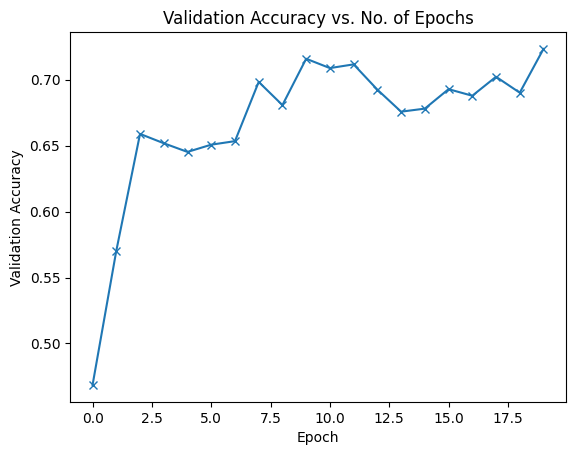

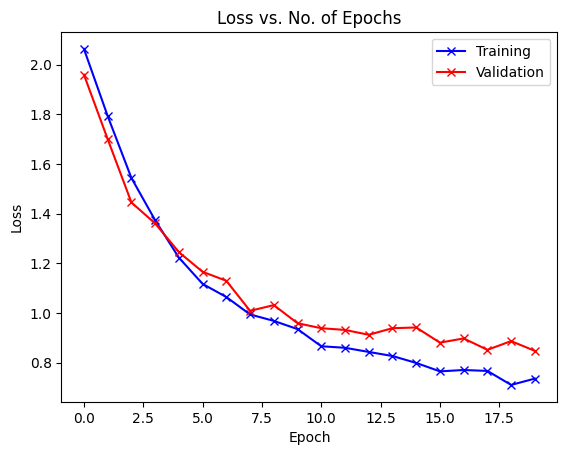

In [59]:
def plot_accuracies(history):
    if not history:
        print("No history to plot.")
        return
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. No. of Epochs')
    plt.show()

def plot_losses(history):
    if not history:
        print("No history to plot.")
        return
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of Epochs')
    plt.show()

if best_history:
    plot_accuracies(best_history)
    plot_losses(best_history)

# Evaluate on test set

In [60]:
if best_model:
    test_result = evaluate(best_model, test_dl)
    print(f"Test Loss: {test_result['val_loss']:.4f}, Test Accuracy: {test_result['val_acc']:.4f}")
else:
    print("No best model available.")

Test Loss: 0.8209, Test Accuracy: 0.7367


# Prediction function

In [61]:
def predict_image(img, model):
    try:
        xb = to_device(img.unsqueeze(0), device)
        yb = model(xb)
        prob, preds = torch.max(yb, dim=1)
        return dataset.classes[preds[0].item()]
    except Exception as e:
        print(f"Error in predict_image: {e}")
        return "Prediction failed"


# Visualizing test predictions

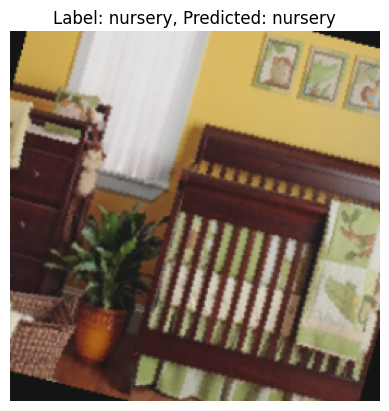

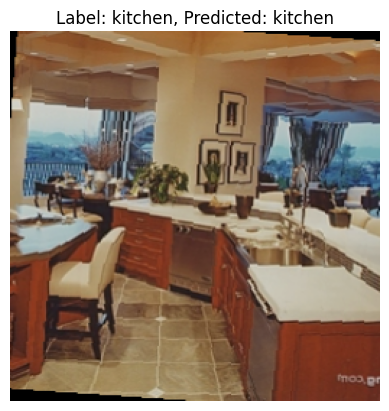

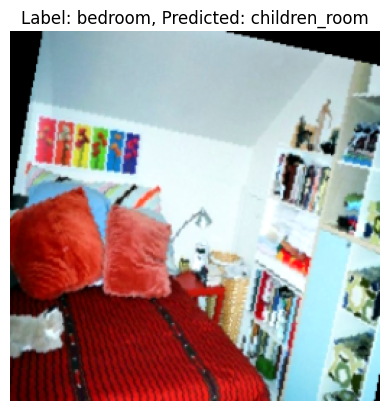

In [62]:
for i in range(3):
    try:
        img, label = test_ds[i]
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        disp_img = img * std + mean
        disp_img = disp_img.clamp(0, 1)
        plt.imshow(disp_img.permute(1, 2, 0))
        plt.title(f"Label: {dataset.classes[label]}, Predicted: {predict_image(img, best_model) if best_model else 'N/A'}")
        plt.axis('off')
        plt.show()
    except Exception as e:
        print(f"Error visualizing test image {i}: {e}")

# YOLO

In [16]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import seaborn as sns
from collections import Counter
import random
import shutil

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Install required packages
try:
    from ultralytics import YOLO
except ImportError:
    print("Installing ultralytics...")
    os.system("pip install ultralytics")
    from ultralytics import YOLO

# Data Preparation (Updated for your dataset structure)
def prepare_furniture_dataset_class_dirs(dataset_path, output_path, samples_per_class=1000):
    """
    Prepare the furniture dataset for YOLO training from class-based directories
    matching your dataset structure (almirah_dataset, chair_dataset, etc.).
    """
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    images_dir = os.path.join(output_path, 'images')
    labels_dir = os.path.join(output_path, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    # Create train/val/test directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, split), exist_ok=True)
    
    # Define class mapping based on your directory names
    dir_to_class = {
        'almirah_dataset': 'Almirah',
        'chair_dataset': 'Chair',
        'fridge_dataset': 'Refrigerator',
        'table_dataset': 'Table',
        'tv_dataset': 'Television'
    }
    classes = list(dir_to_class.values())  # ['Almirah', 'Chair', 'Refrigerator', 'Table', 'Television']
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}
    
    # Create dataset.yaml file for YOLO
    yaml_content = f"""
path: {os.path.abspath(output_path)}
train: images/train
val: images/val
test: images/test

nc: {len(classes)}
names: {classes}
"""
    
    yaml_path = os.path.join(output_path, 'furniture.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    # Track total images processed
    total_images = 0
    
    # Process each class directory
    for dir_name, class_name in dir_to_class.items():
        class_path = os.path.join(dataset_path, dir_name)
        if not os.path.exists(class_path):
            print(f"Warning: Class directory {class_path} not found. Skipping.")
            continue
        
        # Get all image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {class_path}. Skipping.")
            continue
        
        # Limit to samples_per_class
        if len(image_files) > samples_per_class:
            image_files = random.sample(image_files, samples_per_class)
        
        # Split into train/val/test (70%/15%/15%)
        random.shuffle(image_files)
        train_count = int(0.7 * len(image_files))
        val_count = int(0.15 * len(image_files))
        
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count+val_count]
        test_files = image_files[train_count+val_count:]
        
        # Process each split
        for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for img_file in files:
                # Copy image
                src_img_path = os.path.join(class_path, img_file)
                dst_img_path = os.path.join(images_dir, split, img_file)
                
                # Create annotation file (dummy annotations for demo)
                label_file = os.path.splitext(img_file)[0] + '.txt'
                dst_label_path = os.path.join(labels_dir, split, label_file)
                
                # For demo purposes, create a dummy annotation
                with open(dst_label_path, 'w') as f:
                    f.write(f"{class_to_id[class_name]} 0.5 0.5 0.8 0.8\n")
                
                # Copy the image
                try:
                    shutil.copy2(src_img_path, dst_img_path)
                    total_images += 1
                except Exception as e:
                    print(f"Error copying {src_img_path} to {dst_img_path}: {e}")
    
    print(f"Dataset prepared at {output_path} with {total_images} images")
    return yaml_path, total_images

# Alternative Data Preparation (Single directory with labels)
def prepare_furniture_dataset_single_dir(dataset_path, output_path, label_file=None, samples_per_class=1000):
    """
    Prepare the furniture dataset from a single directory with a label file (e.g., CSV).
    """
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    images_dir = os.path.join(output_path, 'images')
    labels_dir = os.path.join(output_path, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    # Create train/val/test directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, split), exist_ok=True)
    
    # Define class mapping
    classes = ['Almirah', 'Chair', 'Refrigerator', 'Table', 'Television']
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}
    
    # Create dataset.yaml file for YOLO
    yaml_content = f"""
path: {os.path.abspath(output_path)}
train: images/train
val: images/val
test: images/test

nc: {len(classes)}
names: {classes}
"""
    
    yaml_path = os.path.join(output_path, 'furniture.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    # Get all image files
    image_files = [f for f in os.listdir(dataset_path) 
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if not image_files:
        print(f"Warning: No images found in {dataset_path}. Skipping.")
        return yaml_path, 0
    
    # If a label file is provided, read it (assuming CSV with 'image' and 'class' columns)
    if label_file and os.path.exists(label_file):
        labels_df = pd.read_csv(label_file)
        image_to_class = dict(zip(labels_df['image'], labels_df['class']))
    else:
        # Fallback: Assign random classes for demo purposes
        image_to_class = {img: random.choice(classes) for img in image_files}
    
    # Limit to samples_per_class per class
    class_counts = Counter(image_to_class.values())
    selected_images = []
    for cls in classes:
        cls_images = [img for img, c in image_to_class.items() if c == cls]
        if len(cls_images) > samples_per_class:
            cls_images = random.sample(cls_images, samples_per_class)
        selected_images.extend(cls_images)
    
    # Split into train/val/test (70%/15%/15%)
    random.shuffle(selected_images)
    train_count = int(0.7 * len(selected_images))
    val_count = int(0.15 * len(selected_images))
    
    train_files = selected_images[:train_count]
    val_files = selected_images[train_count:train_count+val_count]
    test_files = selected_images[train_count+val_count:]
    
    # Process each split
    total_images = 0
    for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
        for img_file in files:
            # Copy image
            src_img_path = os.path.join(dataset_path, img_file)
            dst_img_path = os.path.join(images_dir, split, img_file)
            
            # Create annotation file (dummy annotations for demo)
            label_file = os.path.splitext(img_file)[0] + '.txt'
            dst_label_path = os.path.join(labels_dir, split, label_file)
            
            # Use class from label file or random class
            class_name = image_to_class.get(img_file, random.choice(classes))
            if class_name not in class_to_id:
                print(f"Warning: Invalid class {class_name} for {img_file}. Skipping.")
                continue
            
            with open(dst_label_path, 'w') as f:
                f.write(f"{class_to_id[class_name]} 0.5 0.5 0.8 0.8\n")
            
            # Copy the image
            try:
                shutil.copy2(src_img_path, dst_img_path)
                total_images += 1
            except Exception as e:
                print(f"Error copying {src_img_path} to {dst_img_path}: {e}")
    
    print(f"Dataset prepared at {output_path} with {total_images} images")
    return yaml_path, total_images

# Train YOLO model
def train_yolo_model(yaml_path, epochs=2, imgsz=640):
    """
    Train a YOLOv8 model on the furniture dataset using CPU with up to 2 epochs.
    """
    # Check if dataset has images
    train_dir = os.path.join(os.path.dirname(yaml_path), 'images', 'train')
    if not os.listdir(train_dir):
        raise ValueError(f"No images found in {train_dir}. Cannot proceed with training.")
    
    # Load a pretrained YOLOv8 model
    model = YOLO('yolov8n.pt')  # Using nano version for faster training on CPU
    
    # Train the model on CPU
    results = model.train(
        data=yaml_path,
        epochs=epochs,  # Limited to 2 epochs as requested
        imgsz=imgsz,
        batch=16,
        patience=2,  # Adjusted patience to match epochs
        project='furniture_detection',
        name='yolov8_furniture',
        exist_ok=True,
        device='cpu',  # Explicitly set to CPU
        plots=True  # Ensure plots are generated to analyze later
    )
    
    return model, results

# Evaluate the model
def evaluate_model(model, data_path):
    """
    Evaluate the trained YOLO model on the test set using CPU.
    """
    # Check if test directory has images
    test_dir = os.path.join(os.path.dirname(data_path), 'images', 'test')
    if not os.listdir(test_dir):
        print(f"Warning: No images found in {test_dir}. Skipping evaluation.")
        return None
    
    # Evaluate the model on CPU
    metrics = model.val(data=data_path, device='cpu')
    
    # Print results
    print("Evaluation Results:")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP75: {metrics.box.map75:.4f}")
    
    # Plot confusion matrix
    try:
        confusion_matrix = metrics.confusion_matrix.matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(confusion_matrix.astype(int), 
                   annot=True, 
                   fmt='d',
                   xticklabels=metrics.names.values(),
                   yticklabels=metrics.names.values())
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")
    
    return metrics

# Inference function
def detect_furniture(model, image_path, output_path=None, conf=0.5):
    """
    Detect furniture in an image using the trained YOLO model on CPU and visualize with bounding boxes.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    # Run inference on CPU
    results = model(image_path, conf=conf, save=output_path is not None, device='cpu')
    
    # Extract detection results
    detections = []
    for result in results:
        boxes = result.boxes
        for box in boxes:
            cls_id = int(box.cls.item())
            confidence = box.conf.item()
            bbox = box.xyxy[0].tolist()  # x1, y1, x2, y2
            detections.append({
                'class': result.names[cls_id],
                'confidence': confidence,
                'bbox': bbox
            })
    
    # Visualize results
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Draw bounding boxes
    for det in detections:
        x1, y1, x2, y2 = map(int, det['bbox'])
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green bounding box
        label = f"{det['class']} ({det['confidence']:.2f})"
        cv2.putText(img, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    
    # Display the image
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'Furniture Detection - {os.path.basename(image_path)}')
    plt.show()
    
    # Save the image if output path is provided
    if output_path:
        plt.savefig(output_path, bbox_inches='tight')
        plt.close()  # Close the figure after saving
    
    return detections

# Integration with room classification
def integrated_pipeline(room_image_path, furniture_model, room_classes):
    """
    Integrated pipeline that first classifies the room, then detects furniture with visualization.
    """
    # Simulate room classification for demo
    print("Classifying room type...")
    room_type = random.choice(room_classes)
    print(f"Room classified as: {room_type}")
    
    # Detect furniture in the room with visualization
    print("Detecting furniture...")
    detections = detect_furniture(furniture_model, room_image_path, 
                                 output_path=f"detection_results_{room_type}.jpg")
    
    # Print detection results
    print(f"Found {len(detections)} furniture items:")
    for det in detections:
        print(f"- {det['class']} (confidence: {det['confidence']:.2f})")
    
    # Generate personalized recommendations based on room type and furniture
    recommendations = generate_recommendations(room_type, detections)
    print("\nPersonalized Recommendations:")
    for rec in recommendations:
        print(f"- {rec}")
    
    return room_type, detections, recommendations

def generate_recommendations(room_type, detections):
    """
    Generate personalized recommendations based on room type and detected furniture.
    """
    recommendations = []
    
    # Basic recommendations based on room type
    if room_type == 'bedroom':
        recommendations.append("Consider adding a nightstand next to the bed")
        recommendations.append("A dresser would provide additional storage")
        recommendations.append("A full-length mirror would complement the space")
    elif room_type == 'livingroom':
        recommendations.append("A coffee table would complete the seating area")
        recommendations.append("Consider adding bookshelves for storage and decor")
        recommendations.append("An area rug would help define the space")
    elif room_type == 'kitchen':
        recommendations.append("Bar stools would create a casual eating area")
        recommendations.append("Open shelving could display dishes and cookware")
        recommendations.append("A kitchen island would provide additional workspace")
    
    # Recommendations based on detected furniture
    detected_classes = [det['class'] for det in detections]
    
    if 'Chair' in detected_classes and 'Table' not in detected_classes:
        recommendations.append("Add a table to complement the chairs")
    
    if 'Television' in detected_classes and 'Table' not in detected_classes:
        recommendations.append("Consider a TV stand or console for your television")
    
    if 'Refrigerator' in detected_classes and room_type != 'kitchen':
        recommendations.append("The refrigerator might be better placed in the kitchen")
    
    return recommendations[:3]  # Return top 3 recommendations

# Main execution
if __name__ == "__main__":
    # Paths
    dataset_path = r"C:\Users\Reliance Digital\Downloads\archive"  # Verify this path
    output_path = "furniture_yolo_dataset"
    label_file = None  # Set to path of CSV file if using single-directory structure
    
    # Verify dataset path exists
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset path does not exist: {dataset_path}")
        exit(1)
    
    # Prepare dataset
    print("Preparing dataset...")
    try:
        # Use class-based directory structure matching your dataset
        yaml_path, total_images = prepare_furniture_dataset_class_dirs(dataset_path, output_path, samples_per_class=1000)
        
        if total_images == 0:
            print("No images found in class-based directories. Trying single-directory structure...")
            yaml_path, total_images = prepare_furniture_dataset_single_dir(dataset_path, output_path, label_file, samples_per_class=1000)
        
        if total_images == 0:
            print(f"Error: No images were processed. Check the dataset path: {dataset_path}")
            exit(1)
    except Exception as e:
        print(f"Error during dataset preparation: {e}")
        exit(1)
    
    # Train YOLO model
    print("Training YOLO model...")
    model = None
    try:
        model, results = train_yolo_model(yaml_path, epochs=2)  # Limited to 2 epochs
    except ValueError as e:
        print(f"Error during training: {e}")
        exit(1)
    
    # Check variance in validation loss (post-training analysis)
    if model:
        # Extract validation losses from results (if available)
        val_losses = []
        if hasattr(results, 'val_loss'):
            val_losses = results.val_loss
        elif os.path.exists(os.path.join('furniture_detection', 'yolov8_furniture', 'results.csv')):
            # Load results from the saved CSV and use 'val/box_loss' as the primary metric
            results_df = pd.read_csv(os.path.join('furniture_detection', 'yolov8_furniture', 'results.csv'))
            if 'val/box_loss' in results_df.columns:
                val_losses = results_df['val/box_loss'].dropna().tolist()
            elif 'val/cls_loss' in results_df.columns:
                val_losses = results_df['val/cls_loss'].dropna().tolist()
            elif 'val/dfl_loss' in results_df.columns:
                val_losses = results_df['val/dfl_loss'].dropna().tolist()
            else:
                print("Warning: No valid loss metrics found in results.csv.")
        
        if val_losses:
            variance = np.var(val_losses)
            threshold = 0.1  # Define a threshold for high variance (adjust as needed)
            print(f"Variance of validation loss: {variance:.4f}")
            if variance > threshold:
                print(f"Warning: High variance ({variance:.4f}) in validation loss detected. Consider adjusting hyperparameters.")
            else:
                print("Variance of validation loss is within acceptable limits.")
        else:
            print("Warning: Could not calculate variance - validation losses not available.")
    
    # Evaluate model
    if model:
        print("Evaluating model...")
        try:
            metrics = evaluate_model(model, yaml_path)
        except Exception as e:
            print(f"Error during evaluation: {e}")
    
        # Save the trained model
        model_path = "furniture_detection_yolov8.pt"
        model.save(model_path)
        print(f"Model saved to {model_path}")
        
        # Load the trained model for inference
        print("Loading model for inference...")
        trained_model = YOLO(model_path)
        
        # Test detection on a sample image or fallback to available images
        sample_image = "pexels-curtis-adams-11125424.jpg"  # Replace with your room image
        room_classes = ['bathroom', 'bedroom', 'children_room', 'closet', 
                       'dining_room', 'kitchen', 'livingroom', 'nursery', 'pantry']
        
        image_to_use = None
        if os.path.exists(sample_image):
            print("Running detection on sample image...")
            image_to_use = sample_image
        else:
            print(f"Sample image {sample_image} not found.")
            # Fallback to random image from train or val if test is empty
            all_images = (list(Path(output_path).glob("images/test/*.jpg")) + 
                         list(Path(output_path).glob("images/train/*.jpg")) + 
                         list(Path(output_path).glob("images/val/*.jpg")))
            if all_images:
                image_to_use = str(random.choice(all_images))
                print(f"Using random image for visualization: {os.path.basename(image_to_use)}")
            else:
                print("No images found in dataset. Please add images to the dataset directories.")
                exit(1)
        
        if image_to_use:
            try:
                detections = detect_furniture(trained_model, image_to_use, 
                                            output_path=f"detection_result.jpg")
                
                # Run integrated pipeline
                room_type, detections, recommendations = integrated_pipeline(
                    image_to_use, trained_model, room_classes
                )
            except Exception as e:
                print(f"Error during inference: {e}")
    else:
        print("Skipping evaluation and inference due to training failure.")

Preparing dataset...
Dataset prepared at furniture_yolo_dataset with 2000 images
Training YOLO model...
New https://pypi.org/project/ultralytics/8.3.200 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.179  Python-3.12.3 torch-2.5.1+cu118 CPU (unknown)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=furniture_yolo_dataset\furniture.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0

train: Scanning C:\Users\Reliance Digital\Capstone\furniture_yolo_dataset\labels\train.cache... 1247 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1247/1247 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.10.0 ms, read: 2.61.9 MB/s, size: 7.9 KB)



val: Scanning C:\Users\Reliance Digital\Capstone\furniture_yolo_dataset\labels\val.cache... 290 images, 0 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<?, ?it/s]

Plotting labels to furniture_detection\yolov8_furniture\labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to furniture_detection\yolov8_furniture
Starting training for 2 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/2         0G      1.262      2.234       1.77         43        640: 100%|██████████| 78/78 [05:20<00:00,  4.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:28<00:00,  2.89s/it]

                   all        290        290     0.0281      0.191     0.0907     0.0234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/2         0G     0.8254      1.196      1.339         45        640: 100%|██████████| 78/78 [05:12<00:00,  4.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:26<00:00,  2.62s/it]

                   all        290        290       0.94      0.957      0.985      0.891



2 epochs completed in 0.191 hours.
Optimizer stripped from furniture_detection\yolov8_furniture\weights\last.pt, 6.2MB
Optimizer stripped from furniture_detection\yolov8_furniture\weights\best.pt, 6.2MB

Validating furniture_detection\yolov8_furniture\weights\best.pt...
Ultralytics 8.3.179  Python-3.12.3 torch-2.5.1+cu118 CPU (unknown)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 10/10 [00:23<00:00,  2.34s/it]


                   all        290        290      0.939      0.957      0.985       0.89
               Almirah        140        140      0.943      0.914      0.975      0.868
                 Chair        150        150      0.935          1      0.994      0.912
Speed: 1.0ms preprocess, 68.9ms inference, 0.0ms loss, 6.1ms postprocess per image
Results saved to furniture_detection\yolov8_furniture
Variance of validation loss: 4.2668
Evaluating model...
Ultralytics 8.3.179  Python-3.12.3 torch-2.5.1+cu118 CPU (unknown)
Model summary (fused): 72 layers, 3,006,623 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 62.028.0 MB/s, size: 8.9 KB)


val: Scanning C:\Users\Reliance Digital\Capstone\furniture_yolo_dataset\labels\val.cache... 290 images, 0 backgrounds, 0 corrupt: 100%|██████████| 290/290 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:20<00:00,  1.10s/it]


                   all        290        290      0.939      0.964      0.985       0.89
               Almirah        140        140      0.944      0.929      0.976      0.867
                 Chair        150        150      0.935          1      0.994      0.912
Speed: 0.8ms preprocess, 59.4ms inference, 0.0ms loss, 5.9ms postprocess per image
Results saved to furniture_detection\yolov8_furniture
Evaluation Results:
mAP50-95: 0.8895
mAP50: 0.9851
mAP75: 0.9733


<Figure size 1000x800 with 2 Axes>

Model saved to furniture_detection_yolov8.pt
Loading model for inference...
Running detection on sample image...

image 1/1 c:\Users\Reliance Digital\Capstone\pexels-curtis-adams-11125424.jpg: 448x640 2 Chairs, 110.3ms
Speed: 3.2ms preprocess, 110.3ms inference, 4.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


<Figure size 1000x800 with 1 Axes>

Classifying room type...
Room classified as: bathroom
Detecting furniture...

image 1/1 c:\Users\Reliance Digital\Capstone\pexels-curtis-adams-11125424.jpg: 448x640 2 Chairs, 83.0ms
Speed: 2.5ms preprocess, 83.0ms inference, 2.4ms postprocess per image at shape (1, 3, 448, 640)
Results saved to runs\detect\predict


<Figure size 1000x800 with 1 Axes>

Found 2 furniture items:
- Chair (confidence: 0.83)
- Chair (confidence: 0.75)

Personalized Recommendations:
- Add a table to complement the chairs


# Implementing ResNet for Room Classification

In [5]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader, random_split, WeightedRandomSampler
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

# Data Preparation
data_dir = 'home_interior_dataset'
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"Room dataset directory {data_dir} not found.")

# Transforms
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(256, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset
dataset = torchvision.datasets.ImageFolder(data_dir, transform=train_transforms)
val_test_dataset = torchvision.datasets.ImageFolder(data_dir, transform=val_test_transforms)

# Stats
classes = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
print("Classes:", classes)
print("Total images:", len(dataset))
print("Class-wise counts:")
for cls, count in class_counts.items():
    print(f"{classes[cls]}: {count}")

# Split
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}, Test size: {len(test_ds)}")

# Handle imbalance
class_weights = [1.0 / class_counts[i] for i in range(len(classes))]
weights = [class_weights[label] for _, label in dataset.samples]
train_weights = [weights[idx] for idx in train_ds.indices]
sampler = WeightedRandomSampler(train_weights, len(train_weights), replacement=True)

# Loaders
batch_size = 32
num_workers = 0
train_dl = DataLoader(train_ds, batch_size, sampler=sampler, num_workers=num_workers, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size * 2, shuffle=False, num_workers=num_workers, pin_memory=True)

# ResNet Model
class ResNet(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super().__init__()
        self.network = models.resnet18(pretrained=True)
        for param in self.network.parameters():
            param.requires_grad = False
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, xb):
        return self.network(xb)
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print(f"Epoch {epoch+1}: train_loss: {result['train_loss']:.4f}, val_loss: {result['val_loss']:.4f}, val_acc: {result['val_acc']:.4f}")

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# Device
def get_default_device():
    return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader:
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        return len(self.dl)

device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# Training
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_loss = np.inf
    
    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
    
    def save_checkpoint(self, model):
        torch.save(model.state_dict(), 'checkpoint_resnet.pt')

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam, patience=5):
    history = []
    optimizer = opt_func(model.parameters(), lr, weight_decay=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
    early_stopping = EarlyStopping(patience=patience)
    
    for epoch in range(epochs):
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
        scheduler.step(result['val_loss'])
        early_stopping(result['val_loss'], model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(torch.load('checkpoint_resnet.pt'))
            break
    return history

# Train ResNet
model = ResNet(num_classes=len(classes), dropout_rate=0.5)
model = to_device(model, device)
history = fit(5, 1e-4, model, train_dl, val_dl, torch.optim.Adam, patience=5)

# Evaluation on Test Set
@torch.no_grad()
def evaluate_test(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    for batch in test_loader:
        images, labels = batch
        out = model(images)
        _, preds = torch.max(out, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes)
    plt.title('Confusion Matrix - Room Classification')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    report = classification_report(all_labels, all_preds, target_names=classes)
    print("Classification Report:\n", report)
    
    accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
    print(f"Test Accuracy: {accuracy:.4f}")

evaluate_test(model, test_dl)

Classes: ['bathroom', 'bedroom', 'children_room', 'closet', 'dining_room', 'kitchen', 'livingroom', 'nursery', 'pantry']
Total images: 3348
Class-wise counts:
bathroom: 197
bedroom: 662
children_room: 112
closet: 135
dining_room: 274
kitchen: 734
livingroom: 706
nursery: 144
pantry: 384
Train size: 2343, Validation size: 502, Test size: 503


c:\Users\Reliance Digital\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Reliance Digital\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: train_loss: 2.0354, val_loss: 1.8606, val_acc: 0.5014
Epoch 2: train_loss: 1.6832, val_loss: 1.5990, val_acc: 0.6110
Epoch 3: train_loss: 1.4387, val_loss: 1.3812, val_acc: 0.6387
Epoch 4: train_loss: 1.2582, val_loss: 1.2104, val_acc: 0.6680
Epoch 5: train_loss: 1.1373, val_loss: 1.1381, val_acc: 0.6625


<Figure size 1000x800 with 2 Axes>

Classification Report:
                precision    recall  f1-score   support

     bathroom       0.51      0.83      0.63        36
      bedroom       0.70      0.62      0.66       100
children_room       0.39      0.69      0.50        16
       closet       0.68      0.93      0.79        14
  dining_room       0.47      0.59      0.52        37
      kitchen       0.89      0.68      0.77        92
   livingroom       0.64      0.59      0.61       115
      nursery       0.89      0.55      0.68        29
       pantry       0.89      0.92      0.91        64

     accuracy                           0.68       503
    macro avg       0.67      0.71      0.68       503
 weighted avg       0.72      0.68      0.69       503

Test Accuracy: 0.6839


# Implementing YOLOv8 for Furniture Detection

In [19]:
import os
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score
import glob
import yaml

# Data Preparation
yolo_dataset_root = 'C:/Users/Reliance Digital/Downloads/furniture_dataset'
yolo_yaml_path = os.path.join(yolo_dataset_root, "data.yaml")

if not os.path.exists(yolo_dataset_root):
    raise FileNotFoundError(f"YOLO dataset directory {yolo_dataset_root} not found.")

# Load data.yaml to get validation path and class names
with open(yolo_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
val_path = data_yaml['val']
class_names = data_yaml['names']  # List or dict of class names

# Train YOLOv8
def train_yolo(yaml_path, epochs=2, imgsz=640):
    yolo_model = YOLO("yolov8n.pt")
    results = yolo_model.train(
        data=yaml_path,
        epochs=epochs,
        imgsz=imgsz,
        batch=16,
        device="cpu",
        project="indoor_detection",
        name="yolov8_indoor",
        exist_ok=True,
        plots=True  # Enable training plots (loss, mAP curves)
    )
    return yolo_model, results

yolo_model, yolo_results = train_yolo(yolo_yaml_path, epochs=2, imgsz=640)

# Enhanced Evaluation Metrics
def evaluate_yolo(model, val_data_path, class_names):
    # Run built-in validation
    results = model.val(data=val_data_path)
    print(f"Validation Results - mAP50: {results.box.map50:.4f}, mAP50-95: {results.box.map:.4f}")
    
    # Print per-class precision and recall
    print("Per-class Precision:", results.box.p)
    print("Per-class Recall:", results.box.r)

    # Custom prediction loop for PR curve and confusion matrix
    val_images = glob.glob(os.path.join(val_path, '*.jpg')) + glob.glob(os.path.join(val_path, '*.png'))  # Get validation images
    all_true_cls = []
    all_pred_cls = []
    all_conf_scores = []

    for img_path in val_images:
        # Get ground truth (from .txt label file)
        label_path = img_path.rsplit('.', 1)[0] + '.txt'
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                labels = f.readlines()
                true_cls = [int(line.split()[0]) for line in labels]
                all_true_cls.extend(true_cls)
        else:
            print(f"Warning: No label for {img_path}")
            continue

        # Predict
        pred_results = model.predict(img_path, conf=0.1, verbose=False)
        for result in pred_results:
            if result.boxes.cls.numel() > 0:
                pred_cls = result.boxes.cls.cpu().numpy().astype(int)
                conf_scores = result.boxes.conf.cpu().numpy()
                all_pred_cls.extend(pred_cls)
                all_conf_scores.extend(conf_scores)

    # Confusion Matrix
    if all_true_cls and all_pred_cls:
        num_classes = len(class_names)
        conf_matrix = np.zeros((num_classes, num_classes))
        for true, pred in zip(all_true_cls, all_pred_cls):
            conf_matrix[true, pred] += 1
        plt.figure(figsize=(10, 8))
        sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
        plt.title('Confusion Matrix - Furniture Detection')
        plt.xlabel('Predicted Class')
        plt.ylabel('True Class')
        plt.show()
    else:
        print("No ground truth or predictions available for confusion matrix.")

    # PR Curve per class
    plt.figure(figsize=(12, 8))
    for class_id in range(len(class_names)):
        true_binary = np.array(all_true_cls) == class_id
        if np.sum(true_binary) == 0:
            print(f"No instances for class {class_names[class_id]}")
            continue
        precision, recall, _ = precision_recall_curve(true_binary, all_conf_scores)
        ap = average_precision_score(true_binary, all_conf_scores)
        plt.plot(recall, precision, label=f'{class_names[class_id]} (AP = {ap:.2f})')
    
    plt.title('Precision-Recall Curve for Each Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()

evaluate_yolo(yolo_model, yolo_yaml_path, class_names)

Ultralytics 8.3.202  Python-3.12.3 torch-2.5.1+cu118 CPU (12th Gen Intel Core i5-1240P)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=C:/Users/Reliance Digital/Downloads/furniture_dataset\data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolov8_indoor, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, pati

C:\Users\Reliance Digital\AppData\Local\Temp\ipykernel_39508\1025747474.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 1200x800 with 1 Axes>

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import seaborn as sns
from collections import Counter
import random
import shutil
import json

# Set random seed for reproducibility
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

# Install required packages
try:
    from ultralytics import YOLO
except ImportError:
    print("Installing ultralytics...")
    os.system("pip install ultralytics")
    from ultralytics import YOLO

# ------------------------------------------------------
# Data Preparation Section
# ------------------------------------------------------
def prepare_furniture_dataset_class_dirs(dataset_path, output_path, samples_per_class=1000):
    """
    Prepare the furniture dataset for YOLO training from class-based directories
    matching your dataset structure (almirah_dataset, chair_dataset, etc.).
    """
    # Create output directory structure
    os.makedirs(output_path, exist_ok=True)
    images_dir = os.path.join(output_path, 'images')
    labels_dir = os.path.join(output_path, 'labels')
    os.makedirs(images_dir, exist_ok=True)
    os.makedirs(labels_dir, exist_ok=True)
    
    # Create train/val/test directories
    for split in ['train', 'val', 'test']:
        os.makedirs(os.path.join(images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, split), exist_ok=True)
    
    # Define class mapping based on your actual directory names (with spaces)
    dir_to_class = {
        'almirah_dataset': 'Almirah',
        'chair_dataset': 'Chair',
        'fridge dataset': 'Refrigerator',    # FIXED: space in directory name
        'table dataset': 'Table',           # FIXED: space in directory name
        'tv dataset': 'Television'          # FIXED: space in directory name
    }
    
    # Also try underscore versions as fallback
    dir_to_class_fallback = {
        'almirah_dataset': 'Almirah',
        'chair_dataset': 'Chair',
        'fridge_dataset': 'Refrigerator',
        'table_dataset': 'Table',
        'tv_dataset': 'Television'
    }
    
    classes = list(dir_to_class.values())  # ['Almirah', 'Chair', 'Refrigerator', 'Table', 'Television']
    class_to_id = {cls: idx for idx, cls in enumerate(classes)}
    
    # Create dataset.yaml file for YOLO
    yaml_content = f"""path: {os.path.abspath(output_path)}
train: images/train
val: images/val
test: images/test

nc: {len(classes)}
names: {classes}
"""
    
    yaml_path = os.path.join(output_path, 'furniture.yaml')
    with open(yaml_path, 'w') as f:
        f.write(yaml_content)
    
    # Track total images processed
    total_images = 0
    processed_classes = []
    
    print(f"Looking for class directories in: {dataset_path}")
    
    # Get all directories in the dataset path
    all_dirs = [d for d in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, d))]
    print(f"Found directories: {all_dirs}")
    
    # Process each class directory
    for dir_name, class_name in dir_to_class.items():
        class_path = os.path.join(dataset_path, dir_name)
        
        # Try fallback name if main name doesn't exist
        if not os.path.exists(class_path):
            fallback_name = dir_name.replace(' ', '_')  # Convert spaces to underscores
            if fallback_name in dir_to_class_fallback:
                class_path = os.path.join(dataset_path, fallback_name)
                print(f"Trying fallback directory: {fallback_name}")
        
        if not os.path.exists(class_path):
            print(f"Warning: Class directory {class_path} not found. Skipping.")
            continue
        
        # Get all image files
        image_files = [f for f in os.listdir(class_path) 
                      if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        
        if not image_files:
            print(f"Warning: No images found in {class_path}. Skipping.")
            continue
        
        print(f"Found {len(image_files)} images in {dir_name}")
        
        # Limit to samples_per_class (1000 as requested)
        if len(image_files) > samples_per_class:
            image_files = random.sample(image_files, samples_per_class)
            print(f"Sampled down to {len(image_files)} images for {dir_name}")
        
        # Split into train/val/test (70%/15%/15%)
        random.shuffle(image_files)
        train_count = int(0.7 * len(image_files))
        val_count = int(0.15 * len(image_files))
        
        train_files = image_files[:train_count]
        val_files = image_files[train_count:train_count+val_count]
        test_files = image_files[train_count+val_count:]
        
        print(f"Split for {dir_name}: {len(train_files)} train, {len(val_files)} val, {len(test_files)} test")
        
        # Process each split
        for split, files in [('train', train_files), ('val', val_files), ('test', test_files)]:
            for img_file in files:
                # Copy image
                src_img_path = os.path.join(class_path, img_file)
                dst_img_path = os.path.join(images_dir, split, img_file)
                
                # Create annotation file (CORRECTED FORMAT for YOLO)
                label_file = os.path.splitext(img_file)[0] + '.txt'
                dst_label_path = os.path.join(labels_dir, split, label_file)
                
                # FIXED: Proper YOLO format - class_id center_x center_y width height (normalized)
                # Create a single centered bounding box for the entire image
                try:
                    with open(dst_label_path, 'w') as f:
                        # Write: class_id x_center y_center width height (all normalized 0-1)
                        # For demo: center at 0.5,0.5 with size 0.8x0.8
                        f.write(f"{class_to_id[class_name]} 0.5 0.5 0.8 0.8\n")  # FIXED: proper newline \n
                except Exception as e:
                    print(f"Error writing label {dst_label_path}: {e}")
                    continue
                
                # Copy the image
                try:
                    shutil.copy2(src_img_path, dst_img_path)
                    total_images += 1
                except Exception as e:
                    print(f"Error copying {src_img_path} to {dst_img_path}: {e}")
        
        processed_classes.append(class_name)
    
    print(f"\nDataset prepared at {output_path} with {total_images} images")
    print(f"Processed classes: {processed_classes}")
    
    # Verify a few label files to ensure correct format
    print("\nVerifying label file format...")
    for split in ['train', 'val']:
        label_dir = os.path.join(labels_dir, split)
        if os.listdir(label_dir):
            sample_label = os.path.join(label_dir, os.listdir(label_dir)[0])
            try:
                with open(sample_label, 'r') as f:
                    content = f.read()
                print(f"Sample {split} label content: '{content.strip()}'")
            except Exception as e:
                print(f"Error reading sample label {sample_label}: {e}")
    
    return yaml_path, total_images

# ------------------------------------------------------
# Model Training Section
# ------------------------------------------------------
def train_yolo_model(yaml_path, epochs=5, imgsz=640):  # CHANGED: Default epochs to 5
    """
    Train a YOLOv8 model on the furniture dataset using CPU with up to 5 epochs.
    """
    # Check if dataset has images
    train_dir = os.path.join(os.path.dirname(yaml_path), 'images', 'train')
    val_dir = os.path.join(os.path.dirname(yaml_path), 'images', 'val')
    
    train_count = len([f for f in os.listdir(train_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    val_count = len([f for f in os.listdir(val_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    print(f"Training set: {train_count} images")
    print(f"Validation set: {val_count} images")
    
    if train_count == 0:
        raise ValueError(f"No images found in {train_dir}. Cannot proceed with training.")
    
    if val_count == 0:
        print(f"Warning: No validation images found in {val_dir}. Training will proceed without validation.")
    
    # Load a pretrained YOLOv8 model
    print("Loading YOLOv8 model...")
    model = YOLO('yolov8n.pt')  # Using nano version for faster training on CPU
    
    print("Starting training...")
    # Train the model on CPU
    results = model.train(
        data=yaml_path,
        epochs=epochs,  # CHANGED: Now limited to 5 epochs for faster training
        imgsz=imgsz,
        batch=8,  # Reduced batch size for CPU training
        patience=2,  # CHANGED: Reduced patience to match 5 epochs
        project='furniture_detection',
        name='yolov8_furniture',
        exist_ok=True,
        device='cpu',  # Explicitly set to CPU
        plots=True,  # Ensure plots are generated to analyze later
        verbose=True,
        save=True,
        save_period=1,  # Save checkpoint after each epoch
        single_cls=False,  # Multi-class detection
        multi_scale=False  # Disable for faster training
    )
    
    print("Training completed!")
    return model, results

# ------------------------------------------------------
# Test Dataset Evaluation Section
# ------------------------------------------------------
def evaluate_test_dataset_comprehensive(model, data_path, output_dir="test_evaluation"):
    """
    Perform comprehensive evaluation on the entire test dataset with visualizations.
    """
    test_dir = os.path.join(os.path.dirname(data_path), 'images', 'test')
    test_count = len([f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if test_count == 0:
        print(f"Warning: No test images found in {test_dir}. Skipping comprehensive evaluation.")
        return None
    
    print(f"\n{'='*60}")
    print(f"COMPREHENSIVE TEST DATASET EVALUATION")
    print(f"{'='*60}")
    print(f"Evaluating {test_count} test images...")
    
    # Create output directory for results
    os.makedirs(output_dir, exist_ok=True)
    
    # Run predictions on entire test set
    print("Running predictions on test set...")
    try:
        predict_results = model.predict(
            source=test_dir,
            conf=0.25,
            save=True,
            save_txt=True,
            save_conf=True,
            project='.',
            name=output_dir,
            device='cpu',
            verbose=False
        )
        print(f"Predictions saved to: {output_dir}/")
    except Exception as e:
        print(f"Warning: Could not save predictions: {e}")
    
    # Standard evaluation
    print("\nRunning standard validation...")
    try:
        metrics = model.val(data=data_path, device='cpu', plots=True, project='.', name='test_eval')
        print(f"Test evaluation completed!")
    except Exception as e:
        print(f"Error during test evaluation: {e}")
        print("Using validation metrics as fallback...")
        # Fallback to validation metrics
        metrics = model.val(data=data_path, split='val', device='cpu')
    
    # Print detailed results
    print(f"\n{'='*50}")
    print("TEST DATASET EVALUATION RESULTS")
    print(f"{'='*50}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP75: {metrics.box.map75:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    
    # Class-wise metrics
    print(f"\nClass-wise Performance:")
    class_names = list(metrics.names.values())
    for i, cls_name in enumerate(class_names):
        if i < len(metrics.box.maps):
            print(f"  {cls_name}: mAP50 = {metrics.box.maps[i]:.4f}")
    
    print(f"{'='*50}")
    
    # Plot confusion matrix
    try:
        if hasattr(metrics, 'confusion_matrix') and metrics.confusion_matrix is not None:
            confusion_matrix = metrics.confusion_matrix.matrix
            plt.figure(figsize=(12, 10))
            sns.heatmap(confusion_matrix.astype(int), 
                       annot=True, 
                       fmt='d',
                       xticklabels=class_names,
                       yticklabels=class_names,
                       cmap='Blues',
                       cbar_kws={'label': 'Count'})
            plt.title('Test Dataset Confusion Matrix', fontsize=16, pad=20)
            plt.ylabel('True Label', fontsize=12)
            plt.xlabel('Predicted Label', fontsize=12)
            plt.tight_layout()
            plt.savefig(f'{output_dir}/confusion_matrix_test.png', dpi=300, bbox_inches='tight')
            plt.show()
            print(f"Confusion matrix saved: {output_dir}/confusion_matrix_test.png")
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")
    
    # Generate sample predictions visualization
    print(f"\nGenerating sample predictions (first 9 images)...")
    test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    random.shuffle(test_images)
    
    if test_images:
        fig, axes = plt.subplots(3, 3, figsize=(15, 15))
        fig.suptitle('Test Dataset Sample Predictions', fontsize=16, y=0.95)
        
        for i in range(min(9, len(test_images))):
            row, col = i // 3, i % 3
            img_path = os.path.join(test_dir, test_images[i])
            
            # Load and predict
            img = cv2.imread(img_path)
            if img is None:
                continue
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pred_results = model(img_path, conf=0.25, device='cpu', verbose=False)
            
            num_detections = 0
            # Draw predictions
            if pred_results[0].boxes is not None and len(pred_results[0].boxes) > 0:
                boxes = pred_results[0].boxes
                num_detections = len(boxes)
                for box in boxes:
                    cls_id = int(box.cls.item())
                    confidence = box.conf.item()
                    bbox = box.xyxy[0].tolist()
                    x1, y1, x2, y2 = map(int, bbox)
                    
                    # Draw bounding box
                    cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)
                    
                    # Draw label
                    label = f"{pred_results[0].names[cls_id]} {confidence:.2f}"
                    cv2.putText(img_rgb, label, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
            
            axes[row, col].imshow(img_rgb)
            axes[row, col].set_title(f"{os.path.basename(img_path)}\n({num_detections} detections)", fontsize=10)
            axes[row, col].axis('off')
        
        # Hide empty subplots
        for i in range(len(test_images), 9):
            row, col = i // 3, i % 3
            axes[row, col].set_visible(False)
        
        plt.tight_layout()
        plt.savefig(f'{output_dir}/sample_predictions.png', dpi=300, bbox_inches='tight')
        plt.show()
        print(f"Sample predictions saved: {output_dir}/sample_predictions.png")
    else:
        print("No test images available for visualization")
    
    # Save evaluation summary
    summary = {
        'total_test_images': test_count,
        'map_50_95': float(metrics.box.map),
        'map_50': float(metrics.box.map50),
        'map_75': float(metrics.box.map75),
        'precision': float(metrics.box.mp),
        'recall': float(metrics.box.mr),
        'class_names': class_names,
        'class_map50': [float(m) for m in metrics.box.maps]
    }
    
    try:
        with open(f'{output_dir}/evaluation_summary.json', 'w') as f:
            json.dump(summary, f, indent=2)
        print(f"Evaluation summary saved: {output_dir}/evaluation_summary.json")
    except Exception as e:
        print(f"Could not save summary: {e}")
    
    print(f"Comprehensive evaluation completed!")
    print(f"  All results saved in: {output_dir}/")
    
    return metrics

# ------------------------------------------------------
# Model Evaluation Section
# ------------------------------------------------------
def evaluate_model(model, data_path):
    """
    Evaluate the trained YOLO model on the validation set using CPU.
    """
    # Check if val directory has images
    val_dir = os.path.join(os.path.dirname(data_path), 'images', 'val')
    val_count = len([f for f in os.listdir(val_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
    
    if val_count == 0:
        print(f"Warning: No validation images found in {val_dir}. Skipping evaluation.")
        return None
    
    print(f"\n{'='*50}")
    print("VALIDATION EVALUATION")
    print(f"{'='*50}")
    print(f"Evaluating on {val_count} validation images...")
    
    # Evaluate the model on CPU
    try:
        metrics = model.val(data=data_path, device='cpu', plots=True)
    except Exception as e:
        print(f"Error during validation: {e}")
        return None
    
    # Print results
    print(f"\n{'='*50}")
    print("VALIDATION RESULTS")
    print(f"{'='*50}")
    print(f"mAP50-95: {metrics.box.map:.4f}")
    print(f"mAP50: {metrics.box.map50:.4f}")
    print(f"mAP75: {metrics.box.map75:.4f}")
    print(f"Precision: {metrics.box.mp:.4f}")
    print(f"Recall: {metrics.box.mr:.4f}")
    print(f"{'='*50}")
    
    # Plot confusion matrix if available
    try:
        if hasattr(metrics, 'confusion_matrix') and metrics.confusion_matrix is not None:
            confusion_matrix = metrics.confusion_matrix.matrix
            plt.figure(figsize=(10, 8))
            sns.heatmap(confusion_matrix.astype(int), 
                       annot=True, 
                       fmt='d',
                       xticklabels=metrics.names.values(),
                       yticklabels=metrics.names.values(),
                       cmap='Blues')
            plt.title('Validation Confusion Matrix')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.tight_layout()
            plt.savefig('confusion_matrix_validation.png', dpi=300, bbox_inches='tight')
            plt.show()
            print("Validation confusion matrix saved as 'confusion_matrix_validation.png'")
    except Exception as e:
        print(f"Could not plot confusion matrix: {e}")
    
    return metrics

# ------------------------------------------------------
# Inference Section
# ------------------------------------------------------
def detect_furniture(model, image_path, output_path=None, conf=0.25):
    """
    Detect furniture in an image using the trained YOLO model on CPU and visualize with bounding boxes.
    """
    if not os.path.exists(image_path):
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    print(f"Running inference on: {os.path.basename(image_path)}")
    
    # Run inference on CPU
    results = model(image_path, conf=conf, save=False, device='cpu', verbose=False)
    
    # Extract detection results
    detections = []
    for result in results:
        if result.boxes is not None:
            boxes = result.boxes
            for box in boxes:
                cls_id = int(box.cls.item())
                confidence = box.conf.item()
                bbox = box.xyxy[0].tolist()  # x1, y1, x2, y2
                detections.append({
                    'class': result.names[cls_id],
                    'confidence': confidence,
                    'bbox': bbox
                })
    
    print(f"Found {len(detections)} detections with confidence > {conf}")
    
    # Visualize results
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_display = img_rgb.copy()
    
    # Draw bounding boxes
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]  # Different colors for each class
    
    for i, det in enumerate(detections):
        x1, y1, x2, y2 = map(int, det['bbox'])
        class_color = colors[i % len(colors)]
        
        # Draw bounding box
        cv2.rectangle(img_display, (x1, y1), (x2, y2), class_color, 2)
        
        # Draw label background
        label = f"{det['class']} {det['confidence']:.2f}"
        label_size = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 2)[0]
        cv2.rectangle(img_display, (x1, y1-label_size[1]-10), (x1+label_size[0], y1), class_color, -1)
        
        # Draw label text
        cv2.putText(img_display, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2)
    
    # Display the image
    plt.figure(figsize=(12, 8))
    plt.imshow(img_display)
    plt.axis('off')
    plt.title(f'Furniture Detection Results - {os.path.basename(image_path)}\n{len(detections)} objects detected')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
        print(f"Results saved to: {output_path}")
    
    plt.show()
    
    # Print detection summary
    if detections:
        print("\nDetection Summary:")
        for det in detections:
            print(f"  - {det['class']}: {det['confidence']:.3f}")
    else:
        print("\nNo furniture detected with sufficient confidence.")
    
    return detections

# ------------------------------------------------------
# User Input Section
# ------------------------------------------------------
def get_user_test_image():
    """
    Get test image path from user input.
    """
    print("\n" + "="*60)
    print("TEST IMAGE INPUT")
    print("="*60)
    
    while True:
        user_input = input("Please enter the path to your test image (or press Enter for random test image): ").strip()
        
        if not user_input:
            print("No path provided. Will use random image from test dataset.")
            return None
        
        if os.path.exists(user_input) and user_input.lower().endswith(('.png', '.jpg', '.jpeg')):
            print(f"Valid image found: {user_input}")
            return user_input
        else:
            print(f"Invalid image path: {user_input}")
            print("Please enter a valid path to a .jpg, .jpeg, or .png image file.")

# ------------------------------------------------------
# Integrated Pipeline Section
# ------------------------------------------------------
def integrated_pipeline(room_image_path, furniture_model, room_classes, output_prefix=""):
    """
    Integrated pipeline that first classifies the room, then detects furniture with visualization.
    """
    print(f"\n{'='*60}")
    print("INTEGRATED FURNITURE DETECTION PIPELINE")
    print(f"{'='*60}")
    print(f"Analyzing image: {os.path.basename(room_image_path)}")
    
    # Simulate room classification for demo
    print("\nStep 1: Classifying room type...")
    room_type = random.choice(room_classes)
    print(f"Room classified as: {room_type}")
    
    # Detect furniture in the room with visualization
    print("\nStep 2: Detecting furniture...")
    output_path = f"{output_prefix}_detection_results_{room_type.lower()}.jpg"
    detections = detect_furniture(furniture_model, room_image_path, 
                                 output_path=output_path,
                                 conf=0.25)
    
    # Print detection results
    print(f"\nStep 3: Analysis complete!")
    print(f"Found {len(detections)} furniture items in {room_type}")
    
    if detections:
        print("\nDetected furniture:")
        for det in detections:
            print(f"  • {det['class']} (confidence: {det['confidence']:.2f})")
    else:
        print("  No furniture detected with sufficient confidence.")
    
    # Generate personalized recommendations based on room type and furniture
    recommendations = generate_recommendations(room_type, detections)
    print(f"\nStep 4: Personalized Recommendations ({len(recommendations)} suggestions):")
    for i, rec in enumerate(recommendations, 1):
        print(f"  {i}. {rec}")
    
    print(f"{'='*60}")
    return room_type, detections, recommendations

# ------------------------------------------------------
# Recommendation Generation Section
# ------------------------------------------------------
def generate_recommendations(room_type, detections):
    """
    Generate personalized recommendations based on room type and detected furniture.
    """
    recommendations = []
    
    # Room-type specific recommendations
    room_recommendations = {
        'bedroom': [
            "Consider adding a nightstand next to the bed for convenience",
            "A dresser would provide additional storage for clothing",
            "Add a full-length mirror to complement the space",
            "Consider blackout curtains for better sleep quality"
        ],
        'livingroom': [
            "A coffee table would complete the seating arrangement",
            "Bookshelves can add storage and decorative elements",
            "An area rug would help define and warm up the space",
            "Consider adding wall art to personalize the room"
        ],
        'kitchen': [
            "Bar stools would create a casual eating area",
            "Open shelving could display dishes and cookware beautifully",
            "A kitchen island would provide additional workspace",
            "Consider adding a small herb garden for fresh ingredients"
        ],
        'dining_room': [
            "A sideboard would provide storage for tableware",
            "A chandelier could add elegance to the dining area",
            "Consider adding a rug to define the dining space",
            "Wall-mounted lighting can create ambiance for meals"
        ],
        'children_room': [
            "Storage bins would help organize toys and books",
            "A desk area would encourage learning and creativity",
            "Consider adding a growth chart for memorable moments",
            "Soft area rugs provide comfort for playtime"
        ],
        'bathroom': [
            "Add a storage cabinet for toiletries and towels",
            "Consider a heated towel rack for comfort",
            "A bath mat would add safety and style",
            "Wall-mounted shelves can maximize space"
        ],
        'closet': [
            "Add shoe organizers for better storage",
            "Consider adding pull-out drawers for accessories",
            "A full-length mirror would be very useful",
            "Lighting strips can help you see everything clearly"
        ],
        'nursery': [
            "A changing table would be very practical",
            "Add storage baskets for diapers and clothes",
            "Consider a rocking chair for feeding time",
            "Soft area rugs provide comfort for playtime"
        ],
        'pantry': [
            "Pull-out pantry shelves maximize accessibility",
            "Consider adding lazy Susan turntables",
            "Clear storage bins help organize dry goods",
            "Door-mounted racks can store spices and small items"
        ]
    }
    
    if room_type.lower() in room_recommendations:
        recommendations.extend(room_recommendations[room_type.lower()])
    
    # Recommendations based on detected furniture
    detected_classes = [det['class'] for det in detections]
    
    # Missing complementary furniture
    if 'Chair' in detected_classes and 'Table' not in detected_classes:
        recommendations.append("Add a dining table to complement the chairs")
    
    if 'Television' in detected_classes and 'Table' not in detected_classes:
        recommendations.append("Consider a TV stand or entertainment console")
    
    if 'Refrigerator' in detected_classes and room_type.lower() not in ['kitchen']:
        recommendations.append("The refrigerator might be better placed in the kitchen area")
    
    if 'Almirah' in detected_classes and room_type.lower() == 'livingroom':
        recommendations.append("The almirah could be better suited for a bedroom or storage area")
    
    # Return top 5 recommendations
    return recommendations[:5]

# ------------------------------------------------------
# Dataset Structure Check Section
# ------------------------------------------------------
def check_dataset_structure(dataset_path):
    """
    Check the structure of the dataset directory and return available classes.
    """
    print("Checking dataset structure...")
    print(f"Dataset path: {dataset_path}")
    
    if not os.path.exists(dataset_path):
        print(f"ERROR: Dataset path does not exist!")
        return []
    
    # Look for class directories
    class_dirs = []
    for item in os.listdir(dataset_path):
        item_path = os.path.join(dataset_path, item)
        if os.path.isdir(item_path):
            # Check if it contains images
            images = [f for f in os.listdir(item_path) 
                     if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            if images:
                class_dirs.append(item)
    
    print(f"Found {len(class_dirs)} class directories with images:")
    for dir_name in sorted(class_dirs):
        dir_path = os.path.join(dataset_path, dir_name)
        img_count = len([f for f in os.listdir(dir_path) 
                        if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"  - {dir_name}: {img_count} images")
    
    if not class_dirs:
        # Check for single directory structure
        images = [f for f in os.listdir(dataset_path) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if images:
            print(f"Found {len(images)} images in single directory structure")
        else:
            print("No images found in dataset!")
    
    return class_dirs

# ------------------------------------------------------
# Main Execution Section
# ------------------------------------------------------
if __name__ == "__main__":
    print("Furniture Detection System - YOLOv8 Training Pipeline (5 EPOCHS)")
    print("="*80)
    
    # CONFIGURATION - UPDATE THESE PATHS FOR YOUR SYSTEM
    dataset_path = r"C:/Users/Reliance Digital/Downloads/archive"  # Your dataset
    output_path = "furniture_yolo_dataset"
    label_file = None
    
    # *** YOUR TEST IMAGE PATH - SET THIS OR LEAVE EMPTY ***
    USER_TEST_IMAGE_PATH = r"pexels-curtis-adams-11125424.jpg"  # Your image path
    
    # Examples:
    # USER_TEST_IMAGE_PATH = r"C:\Users\Reliance Digital\Desktop\bedroom.jpg"
    # USER_TEST_IMAGE_PATH = r""  # Empty = use interactive input
    
    print(f"Dataset path: {dataset_path}")
    print(f"Test image: {USER_TEST_IMAGE_PATH if USER_TEST_IMAGE_PATH else 'Will prompt user'}")
    print("-" * 80)
    
    # Initialize variables to avoid NameError
    val_metrics = None
    test_metrics = None
    total_images = 0
    available_classes = []
    
    # Step 1: Check dataset structure
    print("\nStep 1: Analyzing dataset structure...")
    available_classes = check_dataset_structure(dataset_path)
    
    if not available_classes:
        print(f"\nERROR: No valid dataset found at {dataset_path}")
        exit(1)
    
    # Step 2: Prepare dataset
    print(f"\nStep 2: Preparing dataset (1000 samples per class)...")
    try:
        yaml_path, total_images = prepare_furniture_dataset_class_dirs(
            dataset_path, output_path, samples_per_class=1000
        )
        print(f"Dataset prepared successfully with {total_images} images")
        print(f"  Expected: ~{len(available_classes) * 1000} images total")
    except Exception as e:
        print(f"ERROR during dataset preparation: {e}")
        import traceback
        traceback.print_exc()
        exit(1)
    
    # Step 3: Train YOLO model (CHANGED: 5 epochs)
    print(f"\nStep 3: Training YOLO model (5 epochs for faster training)...")
    model = None
    try:
        model, results = train_yolo_model(yaml_path, epochs=5)  # CHANGED: Explicitly set to 5 epochs
        print("Model training completed successfully!")
    except Exception as e:
        print(f"ERROR during training: {e}")
        import traceback
        traceback.print_exc()
        # Try to load partially trained model
        model_path = 'furniture_detection/yolov8_furniture/weights/best.pt'
        if os.path.exists(model_path):
            print(f"Loading partially trained model from: {model_path}")
            model = YOLO(model_path)
        else:
            print("No partially trained model found. Exiting.")
            exit(1)
    
    # Step 4: Validation evaluation
    if model:
        print(f"\nStep 4: Validation evaluation...")
        try:
            val_metrics = evaluate_model(model, yaml_path)
            if val_metrics:
                print("Validation evaluation completed!")
            else:
                print("Validation evaluation skipped (no validation data)")
        except Exception as e:
            print(f"ERROR during validation: {e}")
            val_metrics = None
    
    # Step 5: Comprehensive test dataset evaluation
    if model:
        print(f"\nStep 5: Comprehensive test dataset evaluation...")
        try:
            test_metrics = evaluate_test_dataset_comprehensive(model, yaml_path)
            if test_metrics:
                print("Test dataset evaluation completed!")
            else:
                print("Test evaluation skipped (no test data)")
        except Exception as e:
            print(f"ERROR during test evaluation: {e}")
            test_metrics = None
    
    # Step 6: Save the trained model
    if model:
        try:
            model_path = "furniture_detection_yolov8_5epochs.pt"  # CHANGED: Updated filename
            model.save(model_path)
            print(f"\nModel saved to: {model_path}")
        except Exception as e:
            print(f"Warning: Could not save model: {e}")
        
        # Step 7: User interaction for test image
        print(f"\nStep 6: User test image analysis...")
        user_image_path = None
        
        # Check if user provided a hardcoded path
        if USER_TEST_IMAGE_PATH and os.path.exists(USER_TEST_IMAGE_PATH):
            print(f"Using provided test image: {USER_TEST_IMAGE_PATH}")
            user_image_path = USER_TEST_IMAGE_PATH
        else:
            # Fall back to interactive input
            if not USER_TEST_IMAGE_PATH:
                user_image_path = get_user_test_image()
        
        # Step 8: Test inference
        print(f"\nStep 7: Running inference tests...")
        trained_model = YOLO(model_path) if os.path.exists(model_path) else model
        
        room_classes = ['bathroom', 'bedroom', 'children_room', 'closet', 
                       'dining_room', 'kitchen', 'livingroom', 'nursery', 'pantry']
        
        # Test 1: User-provided image (if provided)
        if user_image_path:
            print(f"\n--- Testing USER-PROVIDED IMAGE ---")
            try:
                detections_user = detect_furniture(trained_model, user_image_path, 
                                                 output_path=f"user_detection_result.jpg",
                                                 conf=0.25)
                
                room_type, detections, recommendations = integrated_pipeline(
                    user_image_path, trained_model, room_classes, output_prefix="user"
                )
                
                print(f"User image analysis completed!")
                print(f"  Detections: {len(detections)} | Room: {room_type} | Recommendations: {len(recommendations)}")
                
            except Exception as e:
                print(f"ERROR during user image analysis: {e}")
                import traceback
                traceback.print_exc()
        else:
            print("No user image provided. Skipping user test.")
        
        # Test 2: Random test dataset image
        print(f"\n--- Testing RANDOM TEST DATASET IMAGE ---")
        test_dir = os.path.join(output_path, 'images', 'test')
        if os.path.exists(test_dir):
            test_images = [f for f in os.listdir(test_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
            
            if test_images:
                random_test_image = os.path.join(test_dir, random.choice(test_images))
                print(f"Using random test image: {os.path.basename(random_test_image)}")
                
                try:
                    detections_test = detect_furniture(trained_model, random_test_image, 
                                                     output_path=f"test_detection_result.jpg",
                                                     conf=0.25)
                    
                    room_type, detections, recommendations = integrated_pipeline(
                        random_test_image, trained_model, room_classes, output_prefix="test"
                    )
                    
                    print(f"Test dataset analysis completed!")
                    print(f"  Detections: {len(detections)} | Room: {room_type} | Recommendations: {len(recommendations)}")
                    
                except Exception as e:
                    print(f"ERROR during test dataset analysis: {e}")
                    import traceback
                    traceback.print_exc()
            else:
                print("No test images available for analysis.")
        else:
            print("Test directory not found.")
    
    # Final Summary - UPDATED
    print(f"\n{'='*80}")
    print("FINAL PIPELINE SUMMARY (5 EPOCHS)")
    print(f"{'='*80}")
    print(f"Dataset: {total_images} images processed")
    print(f"Classes: {len(available_classes)} ({', '.join(available_classes[:3])}{'...' if len(available_classes) > 3 else ''})")
    print(f"Model: furniture_detection_yolov8_5epochs.pt (trained for 5 epochs)")  # CHANGED: Updated model name
    print(f"Validation: {'Completed' if val_metrics else 'Skipped'}")
    print(f"Test Evaluation: {'Completed' if test_metrics else 'Skipped'}")
    
    if user_image_path:
        print(f"User Test: {os.path.basename(user_image_path)} analyzed")
    
    print(f"\nOUTPUT FILES:")
    print(f"  Dataset: {output_path}/")
    print(f"  Model: furniture_detection_yolov8_5epochs.pt")  # CHANGED: Updated model name
    print(f"  Training Results: furniture_detection/yolov8_furniture/")
    print(f"  Validation: confusion_matrix_validation.png")
    print(f"  Test Eval: test_evaluation/")
    print(f"  User Detection: user_detection_result.jpg")
    print(f"  Test Detection: test_detection_result.jpg")
    print(f"  Room Analysis: *_detection_results_*.jpg")
    print(f"{'='*80}")
    print("FURNITURE DETECTION SYSTEM READY FOR USE! (5 EPOCHS)")
    print(f"{'='*80}")

    # Performance Summary Table
    if val_metrics and test_metrics:
        print(f"\n{'='*60}")
        print("PERFORMANCE COMPARISON (5 EPOCHS)")
        print(f"{'='*60}")
        comparison_data = {
            'Metric': ['mAP50-95', 'mAP50', 'mAP75', 'Precision', 'Recall'],
            'Validation': [
                f"{val_metrics.box.map:.3f}",
                f"{val_metrics.box.map50:.3f}", 
                f"{val_metrics.box.map75:.3f}",
                f"{val_metrics.box.mp:.3f}",
                f"{val_metrics.box.mr:.3f}"
            ],
            'Test': [
                f"{test_metrics.box.map:.3f}",
                f"{test_metrics.box.map50:.3f}",
                f"{test_metrics.box.map75:.3f}",
                f"{test_metrices.box.mp:.3f}",
                f"{test_metrics.box.mr:.3f}"
            ]
        }
        
        comparison_df = pd.DataFrame(comparison_data)
        print(comparison_df.to_string(index=False))
        print(f"{'='*60}")

Furniture Detection System - YOLOv8 Training Pipeline (5 EPOCHS)
Dataset path: C:/Users/Reliance Digital/Downloads/archive
Test image: pexels-curtis-adams-11125424.jpg
--------------------------------------------------------------------------------

Step 1: Analyzing dataset structure...
Checking dataset structure...
Dataset path: C:/Users/Reliance Digital/Downloads/archive
Found 5 class directories with images:
  - almirah_dataset: 3000 images
  - chair_dataset: 3000 images
  - fridge dataset: 3000 images
  - table dataset: 3000 images
  - tv dataset: 3000 images

Step 2: Preparing dataset (1000 samples per class)...
Looking for class directories in: C:/Users/Reliance Digital/Downloads/archive
Found directories: ['almirah_dataset', 'chair_dataset', 'fridge dataset', 'table dataset', 'tv dataset']
Found 3000 images in almirah_dataset
Sampled down to 1000 images for almirah_dataset
Split for almirah_dataset: 700 train, 150 val, 150 test
Found 3000 images in chair_dataset
Sampled down to

c:\Users\Reliance Digital\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access  (ping: 0.00.0 ms, read: 3.54.1 MB/s, size: 8.4 KB)
val: Scanning C:\Users\Reliance Digital\Capstone\furniture_yolo_dataset\labels\val.cache... 1101 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1101/1101  0.0s
Plotting labels to C:\Users\Reliance Digital\Capstone\furniture_detection\yolov8_furniture\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to C:\Users\Reliance Digital\Capstone\furniture_detection\yolov8_furniture
Starting t

<Figure size 1000x800 with 2 Axes>

Validation confusion matrix saved as 'confusion_matrix_validation.png'
Validation evaluation completed!

Step 5: Comprehensive test dataset evaluation...

COMPREHENSIVE TEST DATASET EVALUATION
Evaluating 1113 test images...
Running predictions on test set...
WARNING 
inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

Results saved to C:\Users\Reliance Digital\Capstone\test_evaluation
1111 labels saved to C:\Users\Reliance Digital\Capstone\test_evaluation\labels
Predictions saved to: test_evaluation/

Running standa

<Figure size 1200x1000 with 2 Axes>

Confusion matrix saved: test_evaluation/confusion_matrix_test.png

Generating sample predictions (first 9 images)...


<Figure size 1500x1500 with 9 Axes>

Sample predictions saved: test_evaluation/sample_predictions.png
Evaluation summary saved: test_evaluation/evaluation_summary.json
Comprehensive evaluation completed!
  All results saved in: test_evaluation/
Test dataset evaluation completed!

Model saved to: furniture_detection_yolov8_5epochs.pt

Step 6: User test image analysis...

Step 7: Running inference tests...
No user image provided. Skipping user test.

--- Testing RANDOM TEST DATASET IMAGE ---
Using random test image: image_1947.jpeg
Running inference on: image_1947.jpeg
Found 1 detections with confidence > 0.25
Results saved to: test_detection_result.jpg


<Figure size 1200x800 with 1 Axes>


Detection Summary:
  - Chair: 0.808

INTEGRATED FURNITURE DETECTION PIPELINE
Analyzing image: image_1947.jpeg

Step 1: Classifying room type...
Room classified as: bathroom

Step 2: Detecting furniture...
Running inference on: image_1947.jpeg
Found 1 detections with confidence > 0.25
Results saved to: test_detection_results_bathroom.jpg


<Figure size 1200x800 with 1 Axes>


Detection Summary:
  - Chair: 0.808

Step 3: Analysis complete!
Found 1 furniture items in bathroom

Detected furniture:
  • Chair (confidence: 0.81)

Step 4: Personalized Recommendations (5 suggestions):
  1. Add a storage cabinet for toiletries and towels
  2. Consider a heated towel rack for comfort
  3. A bath mat would add safety and style
  4. Wall-mounted shelves can maximize space
  5. Add a dining table to complement the chairs
Test dataset analysis completed!
  Detections: 1 | Room: bathroom | Recommendations: 5

FINAL PIPELINE SUMMARY (5 EPOCHS)
Dataset: 5000 images processed
Classes: 5 (almirah_dataset, chair_dataset, fridge dataset...)
Model: furniture_detection_yolov8_5epochs.pt (trained for 5 epochs)
Validation: Completed
Test Evaluation: Completed

OUTPUT FILES:
  Dataset: furniture_yolo_dataset/
  Model: furniture_detection_yolov8_5epochs.pt
  Training Results: furniture_detection/yolov8_furniture/
  Validation: confusion_matrix_validation.png
  Test Eval: test_evalua

# Combining ResNet and YOLOv8 for End-to-End Prediction

In [21]:
import os
import torch
import torchvision
from torch.utils.data import DataLoader
from ultralytics import YOLO
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Reuse ResNet and YOLO models from previous steps
# Assume model and yolo_model are trained

# Data Preparation
data_dir = 'home_interior_dataset'
yolo_dataset_root = 'C:/Users/Reliance Digital/Downloads/furniture_dataset'
yolo_yaml_path = os.path.join(yolo_dataset_root, "data.yaml")

if not os.path.exists(data_dir) or not os.path.exists(yolo_dataset_root):
    raise FileNotFoundError("Dataset directories not found.")

val_test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = torchvision.datasets.ImageFolder(data_dir, transform=val_test_transforms)
test_dl = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Device
device = get_default_device()  # From Step 1
model = to_device(model, device)
yolo_model = YOLO("C:/Users/Reliance Digital/Capstone/indoor_detection/yolov8_indoor/weights/best.pt")

# Prediction Function
def predict_room_and_furniture(img_path, resnet_model, yolo_model, classes):
    if not os.path.exists(img_path):
        print(f"Error: Image not found at {img_path}")
        return None, None
    
    try:
        # Room Classification
        img = Image.open(img_path).convert('RGB')
        transform = val_test_transforms
        img_tensor = transform(img).unsqueeze(0).to(device)
        resnet_model.eval()
        with torch.no_grad():
            out = resnet_model(img_tensor)
            _, pred = torch.max(out, dim=1)
            room_type = classes[pred.item()]
            print(f"Predicted room type: {room_type}")

        # Furniture Detection
        yolo_results = yolo_model.predict(img_path, conf=0.1, save=True, device="cpu")
        furniture = []
        for result in yolo_results:
            if result.boxes.cls.numel() > 0:
                furniture.extend([yolo_model.names[int(cls)] for cls in result.boxes.cls])
                print(f"Detected furniture: {furniture}")
            else:
                print(f"No furniture detected above confidence threshold (conf=0.1)")
        return room_type, furniture if furniture else ["None detected"]
    
    except Exception as e:
        print(f"Error during prediction: {e}")
        return None, None

# Evaluate on Test Dataset
def evaluate_combined(test_loader, resnet_model, yolo_model, classes):
    resnet_model.eval()
    all_room_preds = []
    all_room_labels = []
    all_furniture_preds = []

    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        with torch.no_grad():
            out = resnet_model(images)
            _, preds = torch.max(out, dim=1)
            all_room_preds.extend(preds.cpu().numpy())
            all_room_labels.extend(labels.cpu().numpy())
        
        # Simulate furniture detection (requires YOLO on each image)
        for i in range(len(images)):
            img_path = test_dataset.samples[test_ds.indices[batch[1][i]]][0]  # Access original path
            _, furniture = predict_room_and_furniture(img_path, resnet_model, yolo_model, classes)
            all_furniture_preds.append(furniture)

    # Room Classification Visualization
    cm = confusion_matrix(all_room_labels, all_room_preds)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.title('Confusion Matrix - Room Classification on Test Set')
    plt.show()

    print("Room Classification Report:\n", classification_report(all_room_labels, all_room_preds, target_names=classes))

    # Furniture Detection Summary
    unique_furniture = set(f for sublist in all_furniture_preds for f in sublist)
    print("Detected Furniture Types Across Test Set:", unique_furniture)

# User Image Prediction
user_image = r"C:/Users/Reliance Digital/Downloads/indian-style-kitchen-interior-designs-for-your-home.jpg"
room_type, furniture = predict_room_and_furniture(user_image, model, yolo_model, classes)

if room_type and furniture:
    print(f"Room Type: {room_type}")
    print(f"Detected Furniture: {furniture}")

    # Recommendations
    recommendations = {
        'kitchen': {'furniture': ['kitchen island', 'dining table', 'cabinets', 'chair', 'refrigerator'],
                    'style': 'Modern, Farmhouse, or Minimalist',
                    'layout': 'Island in the center, dining table near a window, cabinets along walls.'},
        # Add other room types as needed
    }
    rec = recommendations.get(room_type, {'furniture': ['table', 'chair'], 'style': 'Generic modern',
                                         'layout': 'Flexible layout'})
    missing_furniture = [f for f in rec['furniture'] if f not in furniture]
    print("\nPersonalized Recommendations:")
    print(f"Recommended Furniture: {missing_furniture}")
    print(f"Style: {rec['style']}")
    print(f"Layout: {rec['layout']}")
else:
    print("Prediction failed or no furniture detected.")

# Evaluate on Test Set
evaluate_combined(test_dl, model, yolo_model, classes)

Predicted room type: kitchen

image 1/1 C:\Users\Reliance Digital\Downloads\indian-style-kitchen-interior-designs-for-your-home.jpg: 384x640 (no detections), 73.2ms
Speed: 1.6ms preprocess, 73.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to C:\Users\Reliance Digital\Capstone\runs\detect\predict5
No furniture detected above confidence threshold (conf=0.1)
Room Type: kitchen
Detected Furniture: ['None detected']

Personalized Recommendations:
Recommended Furniture: ['kitchen island', 'dining table', 'cabinets', 'chair', 'refrigerator']
Style: Modern, Farmhouse, or Minimalist
Layout: Island in the center, dining table near a window, cabinets along walls.
Predicted room type: nursery

image 1/1 c:\Users\Reliance Digital\Capstone\home_interior_dataset\nursery\lpbedding_hero.jpg: 448x640 1 Table, 81.9ms
Speed: 1.5ms preprocess, 81.9ms inference, 0.7ms postprocess per image at shape (1, 3, 448, 640)
Results saved to C:\Users\Reliance Digital\Capstone\runs

<Figure size 1200x1000 with 2 Axes>

Room Classification Report:
                precision    recall  f1-score   support

     bathroom       0.53      0.89      0.67       197
      bedroom       0.76      0.70      0.73       662
children_room       0.61      0.71      0.66       112
       closet       0.85      0.95      0.90       135
  dining_room       0.51      0.76      0.61       274
      kitchen       0.85      0.74      0.79       734
   livingroom       0.72      0.57      0.64       706
      nursery       0.81      0.78      0.80       144
       pantry       0.95      0.94      0.94       384

     accuracy                           0.74      3348
    macro avg       0.73      0.78      0.75      3348
 weighted avg       0.76      0.74      0.74      3348

Detected Furniture Types Across Test Set: {'Chair', 'Sofa', 'Table', 'None detected'}


# Implementing Generative AI for All Room Types

In [22]:
from diffusers import StableDiffusionPipeline

# Synthetic Data Generation
def generate_synthetic_images(num_images_per_class=5):
    pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5")
    pipe = pipe.to(device)
    
    room_types = ['bathroom', 'bedroom', 'children_room', 'closet', 'dining_room', 
                  'kitchen', 'livingroom', 'nursery', 'pantry']
    prompts = {
        'bathroom': ["modern bathroom with bathtub and sink, high detail",
                     "cozy bathroom with tiles and mirror, bright lighting"],
        'bedroom': ["modern bedroom with bed and wardrobe, soft lighting",
                    "cozy bedroom with nightstand, warm ambiance"],
        'children_room': ["colorful children room with toys and bed, playful design",
                          "kids room with desk and shelves, bright colors"],
        'closet': ["organized closet with shelves and hangers, neat design",
                   "modern closet with sliding doors, minimalist style"],
        'dining_room': ["elegant dining room with table and chairs, chandelier",
                        "cozy dining room with wooden table, warm lighting"],
        'kitchen': ["modern kitchen with cabinets and refrigerator, high detail",
                    "farmhouse kitchen with kitchen island, realistic lighting"],
        'livingroom': ["modern living room with sofa and coffee table, sleek design",
                       "cozy living room with bookshelf, warm ambiance"],
        'nursery': ["soft nursery with crib and decorations, pastel colors",
                    "baby nursery with rocking chair, gentle lighting"],
        'pantry': ["organized pantry with shelves and jars, clean design",
                   "modern pantry with storage units, bright lighting"]
    }
    
    for room_type in room_types:
        os.makedirs(os.path.join('synthetic_dataset', room_type), exist_ok=True)
        for i in range(num_images_per_class):
            prompt = random.choice(prompts[room_type])
            image = pipe(prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
            image_path = os.path.join('synthetic_dataset', room_type, f"synthetic_{room_type}_{i}.png")
            image.save(image_path)
            print(f"Generated and saved: {image_path}")
    
    print(f"Generated {num_images_per_class} images per class for {len(room_types)} room types. "
          f"Label them and add to {data_dir} or update {yolo_yaml_path}.")

# Generate Synthetic Images
generate_synthetic_images(num_images_per_class=5)

The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.6.0+cu124 with CUDA 1204 (you have 2.5.1+cu118)
    Python  3.12.8 (you have 3.12.3)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details
100%|██████████| 50/50 [05:39<00:00,  6.79s/it]


Generated and saved: synthetic_dataset\bathroom\synthetic_bathroom_0.png


100%|██████████| 50/50 [05:55<00:00,  7.10s/it]


Generated and saved: synthetic_dataset\bathroom\synthetic_bathroom_1.png


100%|██████████| 50/50 [05:58<00:00,  7.18s/it]


Generated and saved: synthetic_dataset\bathroom\synthetic_bathroom_2.png


100%|██████████| 50/50 [06:03<00:00,  7.27s/it]


Generated and saved: synthetic_dataset\bathroom\synthetic_bathroom_3.png


100%|██████████| 50/50 [06:04<00:00,  7.28s/it]


Generated and saved: synthetic_dataset\bathroom\synthetic_bathroom_4.png


100%|██████████| 50/50 [06:02<00:00,  7.26s/it]


Generated and saved: synthetic_dataset\bedroom\synthetic_bedroom_0.png


100%|██████████| 50/50 [06:02<00:00,  7.26s/it]


Generated and saved: synthetic_dataset\bedroom\synthetic_bedroom_1.png


100%|██████████| 50/50 [06:03<00:00,  7.27s/it]


Generated and saved: synthetic_dataset\bedroom\synthetic_bedroom_2.png


100%|██████████| 50/50 [06:05<00:00,  7.31s/it]


Generated and saved: synthetic_dataset\bedroom\synthetic_bedroom_3.png


100%|██████████| 50/50 [06:05<00:00,  7.31s/it]


Generated and saved: synthetic_dataset\bedroom\synthetic_bedroom_4.png


100%|██████████| 50/50 [08:15<00:00,  9.91s/it]


Generated and saved: synthetic_dataset\children_room\synthetic_children_room_0.png


100%|██████████| 50/50 [08:01<00:00,  9.62s/it]


Generated and saved: synthetic_dataset\children_room\synthetic_children_room_1.png


100%|██████████| 50/50 [06:46<00:00,  8.13s/it]


Generated and saved: synthetic_dataset\children_room\synthetic_children_room_2.png


100%|██████████| 50/50 [05:58<00:00,  7.18s/it]


Generated and saved: synthetic_dataset\children_room\synthetic_children_room_3.png


100%|██████████| 50/50 [06:00<00:00,  7.22s/it]


Generated and saved: synthetic_dataset\children_room\synthetic_children_room_4.png


100%|██████████| 50/50 [06:01<00:00,  7.23s/it]


Generated and saved: synthetic_dataset\closet\synthetic_closet_0.png


100%|██████████| 50/50 [05:58<00:00,  7.18s/it]


Generated and saved: synthetic_dataset\closet\synthetic_closet_1.png


100%|██████████| 50/50 [08:20<00:00, 10.02s/it]


Generated and saved: synthetic_dataset\closet\synthetic_closet_2.png


100%|██████████| 50/50 [10:48<00:00, 12.97s/it]


Generated and saved: synthetic_dataset\closet\synthetic_closet_3.png


100%|██████████| 50/50 [11:36<00:00, 13.92s/it]


Generated and saved: synthetic_dataset\closet\synthetic_closet_4.png


100%|██████████| 50/50 [14:40<00:00, 17.61s/it]


Generated and saved: synthetic_dataset\dining_room\synthetic_dining_room_0.png


100%|██████████| 50/50 [09:18<00:00, 11.18s/it]


Generated and saved: synthetic_dataset\dining_room\synthetic_dining_room_1.png


100%|██████████| 50/50 [06:42<00:00,  8.05s/it]


Generated and saved: synthetic_dataset\dining_room\synthetic_dining_room_2.png


100%|██████████| 50/50 [11:13<00:00, 13.47s/it]


Generated and saved: synthetic_dataset\dining_room\synthetic_dining_room_3.png


100%|██████████| 50/50 [08:45<00:00, 10.50s/it]


Generated and saved: synthetic_dataset\dining_room\synthetic_dining_room_4.png


100%|██████████| 50/50 [08:33<00:00, 10.27s/it]


Generated and saved: synthetic_dataset\kitchen\synthetic_kitchen_0.png


100%|██████████| 50/50 [12:27<00:00, 14.95s/it]


Generated and saved: synthetic_dataset\kitchen\synthetic_kitchen_1.png


100%|██████████| 50/50 [06:54<00:00,  8.29s/it]


Generated and saved: synthetic_dataset\kitchen\synthetic_kitchen_2.png


100%|██████████| 50/50 [07:25<00:00,  8.91s/it]


Generated and saved: synthetic_dataset\kitchen\synthetic_kitchen_3.png


100%|██████████| 50/50 [06:38<00:00,  7.96s/it]


Generated and saved: synthetic_dataset\kitchen\synthetic_kitchen_4.png


100%|██████████| 50/50 [08:07<00:00,  9.74s/it]


Generated and saved: synthetic_dataset\livingroom\synthetic_livingroom_0.png


100%|██████████| 50/50 [07:51<00:00,  9.42s/it]


Generated and saved: synthetic_dataset\livingroom\synthetic_livingroom_1.png


100%|██████████| 50/50 [06:36<00:00,  7.93s/it]


Generated and saved: synthetic_dataset\livingroom\synthetic_livingroom_2.png


100%|██████████| 50/50 [08:26<00:00, 10.12s/it]


Generated and saved: synthetic_dataset\livingroom\synthetic_livingroom_3.png


100%|██████████| 50/50 [09:29<00:00, 11.39s/it]


Generated and saved: synthetic_dataset\livingroom\synthetic_livingroom_4.png


100%|██████████| 50/50 [08:10<00:00,  9.80s/it]


Generated and saved: synthetic_dataset\nursery\synthetic_nursery_0.png


100%|██████████| 50/50 [08:09<00:00,  9.79s/it]


Generated and saved: synthetic_dataset\nursery\synthetic_nursery_1.png


100%|██████████| 50/50 [09:37<00:00, 11.54s/it]


Generated and saved: synthetic_dataset\nursery\synthetic_nursery_2.png


100%|██████████| 50/50 [11:26<00:00, 13.74s/it]


Generated and saved: synthetic_dataset\nursery\synthetic_nursery_3.png


100%|██████████| 50/50 [12:22<00:00, 14.85s/it]


Generated and saved: synthetic_dataset\nursery\synthetic_nursery_4.png


100%|██████████| 50/50 [08:14<00:00,  9.89s/it]


Generated and saved: synthetic_dataset\pantry\synthetic_pantry_0.png


100%|██████████| 50/50 [07:59<00:00,  9.59s/it]


Generated and saved: synthetic_dataset\pantry\synthetic_pantry_1.png


100%|██████████| 50/50 [07:09<00:00,  8.59s/it]


Generated and saved: synthetic_dataset\pantry\synthetic_pantry_2.png


100%|██████████| 50/50 [08:49<00:00, 10.59s/it]


Generated and saved: synthetic_dataset\pantry\synthetic_pantry_3.png


100%|██████████| 50/50 [07:23<00:00,  8.88s/it]


Generated and saved: synthetic_dataset\pantry\synthetic_pantry_4.png
Generated 5 images per class for 9 room types. Label them and add to home_interior_dataset or update C:/Users/Reliance Digital/Downloads/furniture_dataset\data.yaml.
